# EDA & Modeling - Experiment 5b - Using PCA for dimensional reduction

In [5]:
import os
import importlib

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import sklearn.metrics as skm
from   sklearn.decomposition import PCA
from   sklearn.preprocessing import StandardScaler
from   xgboost import XGBClassifier

import saleslib                         # my custom module
importlib.reload(saleslib)              # reload it since I'm frequently making changes.
from saleslib import LABEL_COLUMN_NAME, RANDOM_STATE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

saleslib.initialize_random_seeds()
saleslib.initialize_display_options()

input_filepath = os.path.join('data', 'raw_CRM_opps_export-dummydata.csv')
df_orig        = saleslib.load_data_raw(input_filepath)
df_exp         = saleslib.full_pipeline(df_orig)        # does a variety of things but does not standardize the data

df       = df_exp.copy()
y        = df[LABEL_COLUMN_NAME]
X        = df.drop(columns=LABEL_COLUMN_NAME, axis=1)

# Standardize the data
sc       = StandardScaler()
X_scaled = sc.fit_transform(X)

In [6]:
param_grid = {
   'max_depth':     [16],
   'n_estimators':  [2, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 250, 500, 600, 750, 1000, 1250, 1500, 1750, 2000, 3500, 5000, 7000, 10000],
   'learning_rate': [0.05]
}

ZERO_DIVISION_VALUE = 0

generic_model = XGBClassifier(
    objective='binary:logistic',
    random_state=123456,
    )

scoring = {
    "Accuracy":             'accuracy',
    "Recall":             skm.make_scorer(skm.recall_score, zero_division=ZERO_DIVISION_VALUE),
    "Precision":          skm.make_scorer(skm.precision_score, zero_division=ZERO_DIVISION_VALUE),           
    "roc_auc":            "roc_auc",
    #"roc_auc_score":      skm.make_scorer(skm.roc_auc_score),              
    "F1":                 skm.make_scorer(skm.f1_score, zero_division=ZERO_DIVISION_VALUE),                  
    #"neg_log_loss":       "neg_log_loss",
    "Brier Score Loss":   skm.make_scorer(skm.brier_score_loss),
    #"auc":                skm.make_scorer(skm.auc),
    }


pca = PCA(n_components=5)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

clf = GridSearchCV(
    generic_model,
    param_grid,
    verbose=2,
    n_jobs=-1,
    cv=7,
    scoring=scoring,
    refit="Brier Score Loss",
    return_train_score=True,
)
clf.fit(X_pca, y)
print(clf.best_score_)
print(clf.best_params_)


Fitting 7 folds for each of 27 candidates, totalling 189 fits
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=2; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=16, n

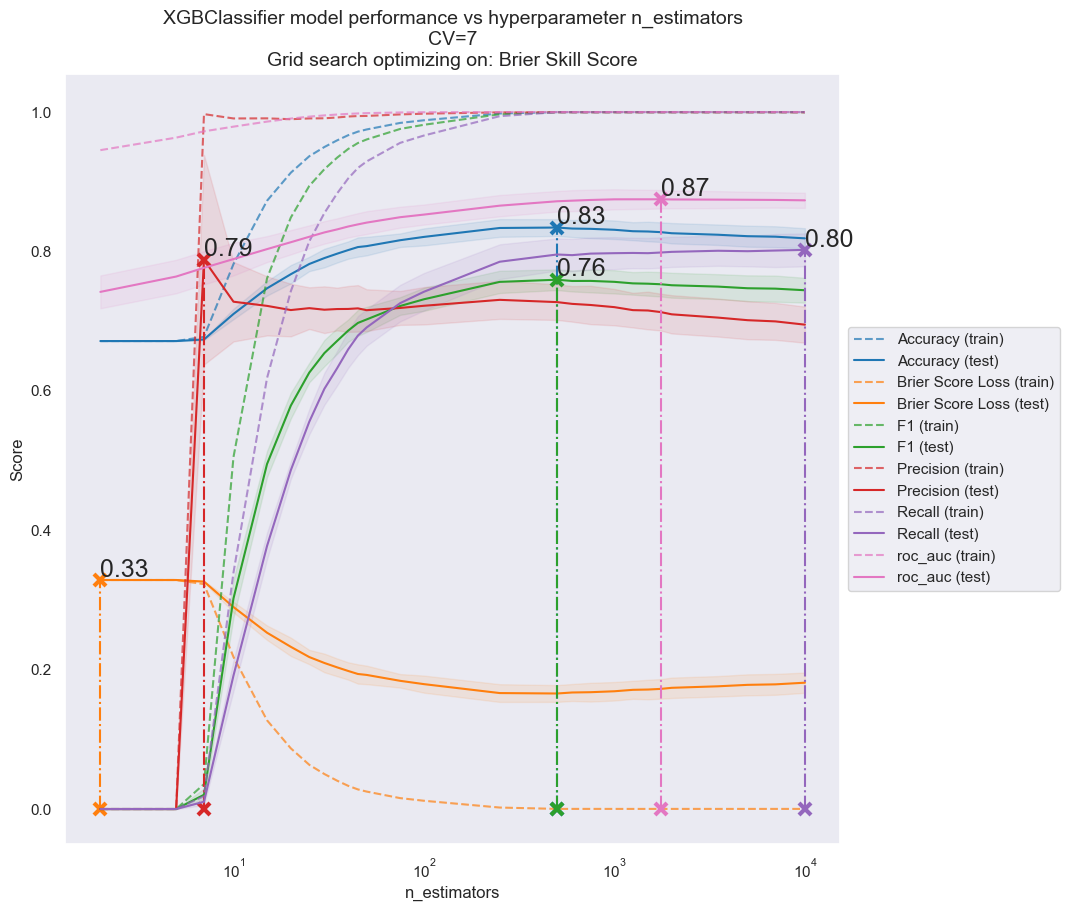

<Axes: title={'center': 'XGBClassifier model performance vs hyperparameter n_estimators\nCV=7\nGrid search optimizing on: Brier Skill Score'}, xlabel='n_estimators', ylabel='Score'>

In [7]:
saleslib.plot_grid_search_scores('n_estimators', clf, scoring, 'Brier Skill Score', scale='log')